In [2]:
from qiskit import *
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
import matplotlib.pyplot as plt
from qutip import Qobj, fidelity, tracedist, concurrence, qeye
import pandas as pd

## Entanglement

**Entanglement** is a fundamental property of quantum systems where two or more particles share correlations that cannot be explained by classical physics.  
In an entangled state, the measurement outcome of one particle is *instantaneously* correlated with the outcome of another, regardless of the distance between them.

Formally, a bipartite pure state $\psi\rangle$ is entangled if it **cannot** be written as a tensor product of single-particle states:

$$
|\psi\rangle \neq |\phi_A\rangle \otimes |\phi_B\rangle
$$

### Example: Singlet state
One of the most famous entangled states is the **singlet state**:

$$
|\psi^{-}\rangle = \frac{1}{\sqrt{2}}\,(|01\rangle - |10\rangle)
$$

This state is maximally entangled and is the basis for many quantum information protocols, such as teleportation and Bell inequality tests.


## Def Entanglement

In [3]:
def entanglement(n=0):
    """
    Create a singlet state (|01> - |10>)/sqrt(2) between Alice and Bob,
    optionally moving Bob's qubit through a chain of SWAP operations
    into auxiliary qubits ("ext").
    
    Args:
        n (int): number of extra qubits (length of the SWAP chain).
    
    Returns:
        QuantumCircuit: Qiskit circuit with the entangled state.
    """

    # 1) Create quantum registers for Alice and Bob
    alice = QuantumRegister(1, 'Alice')
    bob   = QuantumRegister(1, 'Bob')
    regs_q = [alice, bob]

    # 2) If n > 0, add auxiliary register "ext" with n qubits
    if n > 0:
        ext = QuantumRegister(n, 'ext')
        regs_q.append(ext)

    # 3) Create classical register (for measurement if needed)
    c = ClassicalRegister(2, 'c')

    # 4) Build the circuit including all registers
    qc = QuantumCircuit(*regs_q, c, name=f'entanglement(n={n})')

    # 5) Prepare the singlet state: (|01> - |10>)/sqrt(2)
    qc.x(bob[0])          # Bob in |1>
    qc.h(alice[0])        # Alice in (|0> + |1>)/sqrt(2)
    qc.cx(alice[0], bob[0])
    qc.z(bob[0])          # Flip the phase of |10>

    # 6) If n > 0, apply a SWAP chain: Bob ↔ ext[0] ↔ ext[1] ↔ ...
    if n > 0:
        qc.swap(bob[0], ext[0])
        for i in range(1, n):
            qc.swap(ext[i-1], ext[i])

    return qc

## Def Measurement

In [4]:
# List of Pauli matrices
pauli_list = [
    np.eye(2, dtype=complex),                        # I
    np.array([[0, 1], [1, 0]], dtype=complex),       # X
    np.array([[0, -1j], [1j, 0]], dtype=complex),    # Y
    np.array([[1, 0], [0, -1]], dtype=complex),      # Z
]

def measurement_circuit2q(i, j, input_circuit, targetA, targetB):
    """
    Create a circuit that measures targetA in Pauli basis i,
    and targetB in Pauli basis j.
    
    Args:
        i (str or int): Pauli basis for Alice ('X','Y','Z' or 1,2,3).
        j (str or int): Pauli basis for Bob   ('X','Y','Z' or 1,2,3).
        input_circuit (QuantumCircuit): circuit preparing the state.
        targetA, targetB (int): qubit indices.
    
    Returns:
        QuantumCircuit: copy of input_circuit with measurement appended.
    """
    circ = input_circuit.copy()

    # Normalize i, j to string labels
    if isinstance(i, int):
        label_map = ['I','X','Y','Z']
        i = label_map[i]
    if isinstance(j, int):
        label_map = ['I','X','Y','Z']
        j = label_map[j]

    # Basis change for qubit A
    if i == 'X':
        circ.h(targetA)
    elif i == 'Y':
        circ.sdg(targetA)
        circ.h(targetA)

    # Basis change for qubit B
    if j == 'X':
        circ.h(targetB)
    elif j == 'Y':
        circ.sdg(targetB)
        circ.h(targetB)

    # Classical register for results
    creg = ClassicalRegister(2, 'c_tom')
    circ.add_register(creg)

    # Measurements
    circ.measure(targetA, creg[0])
    circ.measure(targetB, creg[1])
    
    return circ


## Create Noise Model

In [5]:
# --- Create noise model ---
noise_model = NoiseModel()

# Depolarizing error: probability p of the state becoming completely mixed
p1 = 0.01  # 1-qubit error
p2 = 0.02  # 2-qubit error

# Thermal relaxation error (T1 and T2 in microseconds, gate time in nanoseconds)
T1 = 50e3  # energy relaxation time
T2 = 70e3  # decoherence time
gate_time_1q = 50     # 1-qubit gate time in ns
gate_time_2q = 200    # 2-qubit gate time in ns

# Define errors
error_1q = depolarizing_error(p1, 1).compose(
    thermal_relaxation_error(T1, T2, gate_time_1q)
)
error_2q = depolarizing_error(p2, 2).compose(
    thermal_relaxation_error(T1, T2, gate_time_2q).expand(
        thermal_relaxation_error(T1, T2, gate_time_2q)
    )
)

# Associate errors with quantum gates
noise_model.add_all_qubit_quantum_error(error_1q, ["u1", "u2", "u3", "h", "x", "y", "z", "sdg"])
noise_model.add_all_qubit_quantum_error(error_2q, ["cx", "swap"])

# Measurement error
meas_error = depolarizing_error(0.02, 1)
noise_model.add_all_qubit_quantum_error(meas_error, ["measure"])

# Backend with noise
backend = AerSimulator(noise_model=noise_model)

## Def Tomography

In [6]:
def tomography2q_Noises(my_circuit, targetA, targetB, shots):
    """Performs 2-qubit state tomography with noise"""
    bases = ['I', 'X', 'Y', 'Z']
    expectation = {}

    for i in bases:
        for j in bases:
            if i == 'I' and j == 'I':
                expectation[(i, j)] = 1.0
                continue

            # Create measurement circuit for current basis
            circ = measurement_circuit2q(i, j, my_circuit, targetA, targetB)
            tcirc = transpile(circ, backend,
                            basis_gates=['swap','h','x','y','z','h','cx','measure','sdg'],
                            optimization_level=0)
            
            # Execute on noisy backend
            result = backend.run(tcirc, shots=shots).result()
            counts = result.get_counts()

            # Calculate state probabilities
            p00 = sum(cnt for bits, cnt in counts.items() if bits[1] == '0' and bits[0] == '0')
            p01 = sum(cnt for bits, cnt in counts.items() if bits[1] == '0' and bits[0] == '1')
            p10 = sum(cnt for bits, cnt in counts.items() if bits[1] == '1' and bits[0] == '0')
            p11 = sum(cnt for bits, cnt in counts.items() if bits[1] == '1' and bits[0] == '1')
            total = p00 + p01 + p10 + p11 or 1

            # Calculate expectation value for this basis
            if i == 'I' and j != 'I':
                Eij = (p00 + p10 - p01 - p11) / total
            elif j == 'I' and i != 'I':
                Eij = (p00 + p01 - p10 - p11) / total
            else:
                Eij = (p00 - p01 - p10 + p11) / total

            expectation[(i, j)] = float(Eij)

    # Reconstruct density matrix
    rho = np.zeros((4, 4), dtype=complex)
    for ii, i in enumerate(bases):
        for jj, j in enumerate(bases):
            rho += expectation[(i, j)] * np.kron(pauli_list[ii], pauli_list[jj])
    rho /= 4.0
    
    # Convert to QuTiP quantum object
    rho_real = Qobj(rho)

    return rho_real

## Creating the Singlet State $\ket{\psi^{-}}$

In [7]:
psi_singlet = (1/np.sqrt(2)) * np.array([0, 1, -1, 0])
rho_ideal = np.outer(psi_singlet, psi_singlet.conj())

rho_ideal = Qobj(rho_ideal)


In [8]:
def relative_entropy_reg(rho, sigma, eps=1e-12):
    """
    Entropia relativa regularizada (sempre finita).
    Versão mais robusta numericamente.
    """
    rho = Qobj(rho)
    sigma = Qobj(sigma)
    d = rho.shape[0]
    I = qeye(d)

    # Regularização mais forte
    rho_reg = (1 - eps) * rho + eps * I / d
    sigma_reg = (1 - eps) * sigma + eps * I / d

    # Normalizar para garantir traço 1
    rho_reg = rho_reg / rho_reg.tr()
    sigma_reg = sigma_reg / sigma_reg.tr()

    # Autovalores e autovetores com tratamento numérico
    evals_rho, evecs_rho = rho_reg.eigenstates()
    evals_sigma, evecs_sigma = sigma_reg.eigenstates()

    # Garantir que autovalores sejam positivos
    evals_rho = np.maximum(evals_rho, eps)
    evals_sigma = np.maximum(evals_sigma, eps)

    # Reconstruir matrizes com autovalores regularizados
    rho_reg = sum([ev * (vec * vec.dag()) for ev, vec in zip(evals_rho, evecs_rho)])
    sigma_reg = sum([ev * (vec * vec.dag()) for ev, vec in zip(evals_sigma, evecs_sigma)])

    # Construção dos logs com autovalores já regularizados
    log_rho = sum([np.log(ev) * (vec * vec.dag()) for ev, vec in zip(evals_rho, evecs_rho)])
    log_sigma = sum([np.log(ev) * (vec * vec.dag()) for ev, vec in zip(evals_sigma, evecs_sigma)])

    # Entropia relativa - garantir resultado real
    S = (rho_reg * (log_rho - log_sigma)).tr()
    
    # Extrair parte real e verificar
    S_real = np.real(S)
    if np.iscomplex(S):
        # Se ainda for complexo, usar apenas a parte real
        S_real = np.real(S)
        # Verificar se a parte imaginária é insignificante
        if abs(np.imag(S)) > 1e-10:
            print(f"Aviso: parte imaginária significativa: {np.imag(S)}")
    
    return float(S_real)


## Noisy SWAP Chain 

In [17]:
# Maximum number of SWAPs
num_swaps = 12

# Guardar resultados em lista de dicionários
results = []

for n in range(1, num_swaps + 1):
    # Circuito com n SWAPs
    circuit = entanglement(n)
    rho = tomography2q_Noises(circuit, targetA=0, targetB=n+1, shots=100000)

    # Métricas
    F = fidelity(rho_ideal, rho)
    D = tracedist(rho_ideal, rho)
    rho.dims = [[2, 2], [2, 2]]
    C = concurrence(rho)
    
    # Armazena resultados
    results.append({
        "SWAPs": n,
        "Fidelity": F,
        "Trace Distance": D,
        "Concurrence": C
    })

# Converte em DataFrame
df_results = pd.DataFrame(results)
print(df_results.round(6))


    SWAPs  Fidelity  Trace Distance  Concurrence
0       1  0.950642        0.096335     0.807779
1       2  0.942409        0.111872     0.776958
2       3  0.934016        0.127710     0.745414
3       4  0.926844        0.141096     0.719304
4       5  0.918708        0.156052     0.689398
5       6  0.911721        0.168805     0.663644
6       7  0.903695        0.183482     0.634605
7       8  0.896432        0.196613     0.608545
8       9  0.889230        0.209578     0.583395
9      10  0.883363        0.219939     0.562437
10     11  0.875583        0.233629     0.535732
11     12  0.869189        0.244866     0.513240


## Plotagem do gráficos 

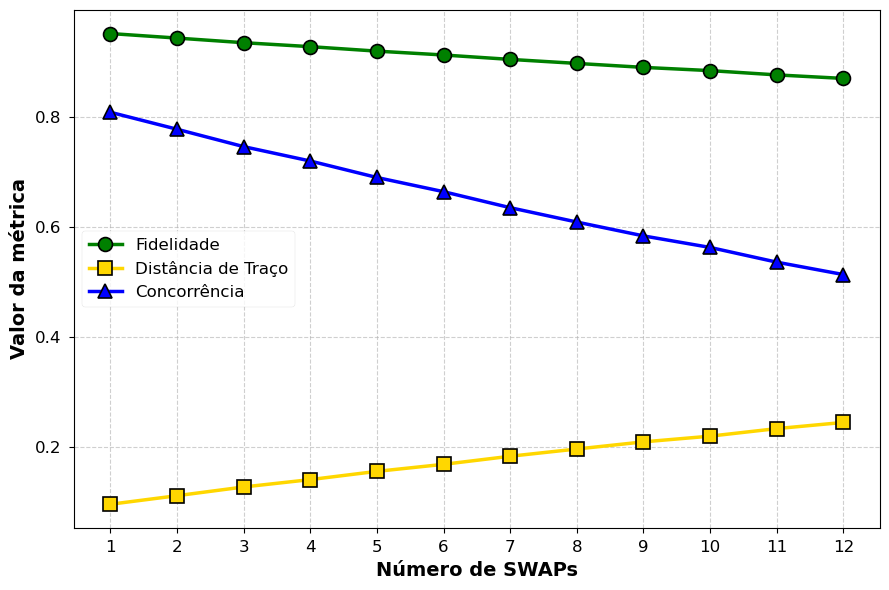

Dados utilizados no gráfico:
SWAPs: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Fidelidade: [0.95064189 0.94240915 0.93401552 0.92684411 0.91870834 0.9117209
 0.90369519 0.89643182 0.88923    0.88336289 0.87558266 0.86918928]
Distância de Traço: [0.09633466 0.11187201 0.12770951 0.14109621 0.15605187 0.16880546
 0.18348182 0.19661341 0.20957761 0.2199391  0.23362873 0.24486648]


In [22]:

# Extrair ados do DataFrame df_results
SWAP_N = df_results['SWAPs'].values
F_N = df_results['Fidelity'].values
D_N = df_results['Trace Distance'].values
C_N = df_results['Concurrence'].values

# Set visual style
plt.style.use("seaborn-v0_8-paper")

# Create figure
plt.figure(figsize=(9,6))

# Fidelity (verde)
plt.plot(SWAP_N, F_N, marker="o", markersize=10, color="green",
         markerfacecolor="green", markeredgecolor="black",
         markeredgewidth=1.2, linewidth=2.5, label="Fidelidade")

# Trace Distance (amarelo)
plt.plot(SWAP_N, D_N, marker="s", markersize=10, color="gold",
         markerfacecolor="gold", markeredgecolor="black",
         markeredgewidth=1.2, linewidth=2.5, label="Distância de Traço")

# Relative Entropy (vermelho)
plt.plot(SWAP_N, C_N, marker="^", markersize=10, color="blue",
         markerfacecolor="blue", markeredgecolor="black",
         markeredgewidth=1.2, linewidth=2.5, label="Concorrência")

# Labels and title
plt.xlabel("Número de SWAPs", fontsize=14, fontweight="bold")
plt.ylabel("Valor da métrica", fontsize=14, fontweight="bold")

plt.xticks(SWAP_N, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Legend
plt.legend(fontsize=12, frameon=True, loc="center left")

plt.tight_layout()
plt.show()

# Mostrar os dados que estão sendo plotados
print("Dados utilizados no gráfico:")
print(f"SWAPs: {SWAP_N}")
print(f"Fidelidade: {F_N}")
print(f"Distância de Traço: {D_N}")

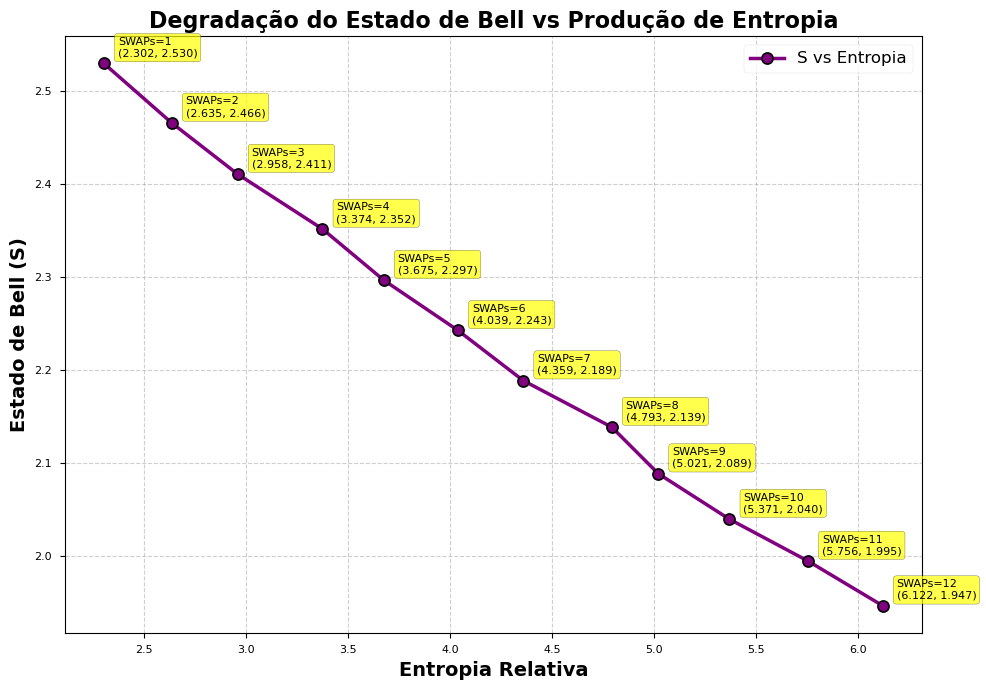

Análise da Relação S vs Entropia:
SWAPs  1: Entropia = 2.302, S = 2.530
SWAPs  2: Entropia = 2.635, S = 2.466
SWAPs  3: Entropia = 2.958, S = 2.411
SWAPs  4: Entropia = 3.374, S = 2.352
SWAPs  5: Entropia = 3.675, S = 2.297
SWAPs  6: Entropia = 4.039, S = 2.243
SWAPs  7: Entropia = 4.359, S = 2.189
SWAPs  8: Entropia = 4.793, S = 2.139
SWAPs  9: Entropia = 5.021, S = 2.089
SWAPs 10: Entropia = 5.371, S = 2.040
SWAPs 11: Entropia = 5.756, S = 1.995
SWAPs 12: Entropia = 6.122, S = 1.947

Taxa média de degradação: -0.1569 (ΔS/ΔEntropia)


In [ ]:


# Seus dados
SWAPs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
S_bell = [2.587, 2.530, 2.466, 2.411, 2.352, 2.297, 2.243, 2.189, 2.139, 2.089, 2.040, 1.995, 1.947]
entropia = [2.301516, 2.634686, 2.957809, 3.374013, 3.674735, 4.038602, 4.359326, 4.793249, 5.021484, 5.370789, 5.756229, 6.12250]

# Alinhar os dados: S_bell de SWAPs 1-12 para corresponder à entropia
S_bell_entropia = S_bell[1:]  # SWAPs 1-12

# Set visual style
plt.style.use("seaborn-v0_8-paper")

# Create figure
plt.figure(figsize=(10, 7))

# Gráfico: Estado de Bell (S) vs Entropia Relativa
# AGORA: X = Entropia, Y = S (Estado de Bell)
plt.plot(entropia, S_bell_entropia, marker="o", markersize=8, color="purple",
         markerfacecolor="purple", markeredgecolor="black",
         markeredgewidth=1.2, linewidth=2.5, label="S vs Entropia")

# Labels and title (CORRIGIDO)
plt.xlabel("Entropia Relativa", fontsize=14, fontweight="bold")
plt.ylabel("Estado de Bell (S)", fontsize=14, fontweight="bold")
plt.title("Degradação do Estado de Bell vs Produção de Entropia", fontsize=16, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)

# Adicionar valores nos pontos
for i, (x, y) in enumerate(zip(entropia, S_bell_entropia)):
    plt.annotate(f'SWAPs={i+1}\n({x:.3f}, {y:.3f})', 
                 (x, y), textcoords="offset points", 
                 xytext=(10,5), ha='left', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# Legend
plt.legend(fontsize=12, frameon=True, loc="upper right")

plt.tight_layout()
plt.show()

# Análise da relação
print("Análise da Relação S vs Entropia:")
print("=" * 40)
for i, (ent, s_val) in enumerate(zip(entropia, S_bell_entropia)):
    print(f"SWAPs {i+1:2d}: Entropia = {ent:.3f}, S = {s_val:.3f}")

# Calcular taxa de degradação
degradacao_S = []
for i in range(1, len(S_bell_entropia)):
    delta_S = S_bell_entropia[i] - S_bell_entropia[i-1]
    delta_entropia = entropia[i] - entropia[i-1]
    taxa = delta_S / delta_entropia if delta_entropia != 0 else 0
    degradacao_S.append(taxa)

print(f"\nTaxa média de degradação: {np.mean(degradacao_S):.4f} (ΔS/ΔEntropia)")